# Introduction, Description
This notebook is dedicated to the development of a pipeline that perform a quality assessment of an eeg signal.
The different metrics will be calculated:
- Average Root Mean Square (RMS) of a sliding window
- Maximum Gradient of a sliding window
- Zero Crossing Rate of a sliding window
- Complexity of the signal (Hjorth's parameters) of a sliding window
- Kurtosis of a sliding window
- Skewness of a sliding window
- Variance of a sliding window
- Range of a sliding window
- Interquartile range of a sliding window
- Signal to Noise Ratio (SNR)
    - Time domain: 
        - ECG based epochs (signal = average across epochs, noise = std across epochs) need to be lowered
        - TR based epochs (signal = average across epochs, noise = std across epochs) need to be lowered
        - EEG based epochs (signal = average across epochs, noise = std across epochs) need to be increased
    - Frequency domain:
        - Gradient artifacts (signal = peak frequency of the cross-correlation of the non-cleaned signal, noise = average of the n surrounding bins around the peak)
        - Base frequency of the task (signal = amplitude at the base freqeuency, noise = average of the n surrounding bins around the peak)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_spectrums as spectrums_package
raw = mne.io.read_raw_edf(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf', 
    preload=True)
spectrum_object = spectrums_package.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

Extracting EDF parameters from /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156749  =      0.000 ...   626.996 secs...


In [32]:
%matplotlib qt
channel = 1
f_min = 0
f_max = 40
obj = snr
channels = ['ECG']
def get_channel_index(channel_list):
    return [obj.info['ch_names'].index(channel) for channel in channel_list]
def plot_tagging(channels = ['ECG'],
                 f_min = 0,
                 f_max = 40,
                 obj = obj):
    channel_index = get_channel_index(channels)
    
    if len(channels) > 1:
        
    index_f_min = obj._get_frequency_index(f_min) + int( obj.sampling_rate)
    index_f_max = obj._get_frequency_index(f_max)
    magnitude = obj.get_peak_magnitude_in_window((17, 20))
    max_spectrum = np.max(obj.spectrum[channels,index_f_min:index_f_max])
    plt.plot(obj.frequencies[index_f_min:index_f_max], 
            obj.spectrum[channel,index_f_min:index_f_max].T,
            color = 'black',
            alpha = 0.5,
            )
    freq_window = fft.frequencies[magnitude['window_idx'][0]:magnitude['window_idx'][1]]
    plt.fill_between(freq_window, 
                    y1 = 6*max_spectrum, 
                    color='orange', 
                    alpha=0.3, 
                    label="Search Window",
                    )
    plt.axhline(magnitude['peak_magnitude'][channel], 
                color='r', 
                linewidth=1, 
                alpha=0.5, 
                label="Peak Magnitude",
                )
    plt.axvline(magnitude['peak_frequency_Hz'][channel], 
                color='g', 
                linewidth=1, 
                alpha =  0.5, 
                label="Peak Frequency",
                )
    y_min = np.min(obj.spectrum[channel,:])
    y_max = 6*max_spectrum/5
    plt.ylim(y_min, y_max)
    plt.xlim(f_min, f_max)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (V^2/Hz)')
    plt.text(magnitude['peak_frequency_Hz'][channel]+f_max/100, 
            magnitude['peak_magnitude'][channel]+y_max/100,
            f"""{np.round(magnitude['peak_magnitude'][channel],3)}{obj.units} 
    {np.round(magnitude['peak_frequency_Hz'][channel],2)} Hz""",
            fontsize=8)
    plt.legend()

[10659, 12540]


In [36]:
l = [1,2,3,4,5,6,7,8,9,10]
l[3]

4

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_spectrums, signal_metrics 
raw = mne.io.read_raw_edf(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf', 
    preload=True,
    encoding='latin1')
spectrum_object = frequency_spectrums.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()
time_window = 1
overlap = 0.5
data = raw.get_data()
metrics = {
    channel_name:
    {
    'average_rms': list(),
    'max_gradient': list(),
    'zero_crossing_rate': list(),
    'hjorth_mobility': list(),
    'hjorth_complexity': list(),
    'kurtosis': list(),
    'skewness': list(),
    'variance': list(),
    'signal_range': list(),
    'signal_IQR': list(),
    }
    for channel_name in raw.info['ch_names']
    
}
starts = np.arange(0, data.shape[1], int((time_window*raw.info['sfreq']))*overlap)
ends = starts + int((time_window*raw.info['sfreq']))

for channel_nb in range(data.shape[0]):
    for start, end in zip(starts, ends):
        if end > data.shape[1]:
            break
        segment = data[channel_nb, int(start):int(end)]
        ch_name = raw.info['ch_names'][channel_nb]
        for metric in metrics[ch_name]:
            metrics[ch_name][metric].append(getattr(signal_metrics, metric)(segment))
        
        metrics[ch_name]['amplitudes']


Extracting EDF parameters from /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156499  =      0.000 ...   625.996 secs...


/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_80533/2102823342.py:5: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(


In [17]:
metrics[str(raw.info['ch_names'][channel_nb])][metric].append(getattr(signal_metrics, metric)(segment))

KeyError: 'Fp1'

In [30]:
raw.info['ch_names'][channel_nb].encode('utf-8').decode('utf-8')

'Fp1'

In [16]:
test = {'a': {'e':1}, 'b': 2}
l = ['a', 'b', 'e']
test[l[0]]

1

In [11]:
metrics['Fp1']

{'average_rms': [],
 'max_gradient': [],
 'zero_crossing_rate': [],
 'hjorth_mobility': [],
 'hjorth_complexity': [],
 'kurtosis': [],
 'skewness': [],
 'variance': [],
 'signal_range': [],
 'signal_IQR': []}

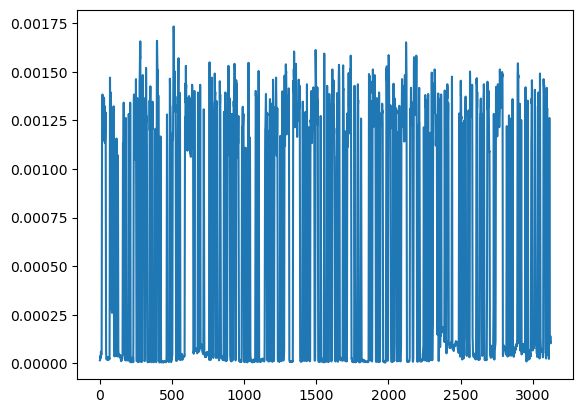

In [63]:
import matplotlib.pyplot as plt
plt.plot(metrics['Fp2']['signal_IQR'])

In [2]:
str(half_spectrum.dtype)

NameError: name 'half_spectrum' is not defined

In [1]:
from EEG_quality_assessment import frequency_spectrums as spectrums_package

In [7]:
t = __import__('frequency_spectrums')

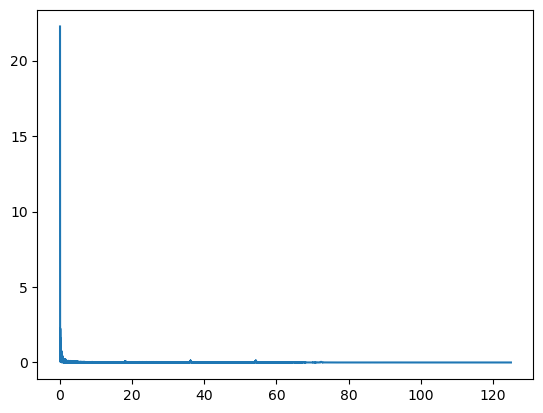

In [34]:
import matplotlib.pyplot as plt
plt.plot(frequencies,np.abs(half_spectrum[0,:]))

In [1]:
a = 'string'
type(a) == str

True